In [3]:
# run me first!

from sklearn.linear_model import LogisticRegression
from timeit import default_timer as timer
from datetime import timedelta
import os
from sklearn import preprocessing
import numpy as np
from read_scripts import dict_2_arr 
from read_scripts import read_dataset 
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import PCA

task = "remote_homology"

def fit_logistic(X, y):
    start = timer()
    clf = LogisticRegression(max_iter=5000)
    clf.fit(X, y)
    end = timer()
    print(f"fit time: ", timedelta(seconds=end-start))
    
    train_score = clf.score(X, y)
    print(f"model train score: ", train_score)
    
    # when run will play a ping sound!
    os.system("printf '\a'")
    os.system("printf '\a'")
    os.system("printf '\a'")
    print("Done!")
    
    return clf


In [4]:
# takes an array of dict_data
# and combines embeddings by averaging with self then appending with other
# convers to array with labels and returns
def ensemble_append_mean_reps(dicts, labels):
    
    new_dict = dict()
    keys = dicts[0].keys()
    for key in keys:
        seqs = []
        for d in dicts:
            seq = np.mean(d[key], axis=0)
            seq = preprocessing.normalize([seq], norm='l2')
            seqs.append(seq)
        combined_seqs = np.concatenate(seqs, axis=1)
        new_dict[key] = combined_seqs

    emb_size = list(new_dict.values())[0].shape[1]
    X = np.zeros((len(new_dict), emb_size))
    y = np.zeros(len(new_dict))
    
    i = 0
    for key in new_dict:
        X[i] = new_dict[key]
        y[i] = labels[key]
        i += 1
        
    return X, y

In [19]:
y_train = read_dataset('label', task, "train")
X_train_e = read_dataset('elmo', task, "train")
X_train_u = read_dataset('unirep', task, "train")
X_train_t = read_dataset('transformer', task, "train")

In [21]:
X_train_app, y_train = ensemble_append_mean_reps([X_train_e, X_train_u, X_train_t], y_train)
scaler = preprocessing.StandardScaler().fit(X_train_app)
X_train_app = scaler.transform(X_train_app)

print(X_train_app.shape)
print(y_train.shape)

(12305, 3692)
(12305,)


In [22]:
clf = fit_logistic(X_train_app, y_train)

fit time:  0:43:56.453212


In [25]:
for split in ['valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']:
    X_test_e = read_dataset('elmo', task, split)
    X_test_u = read_dataset('unirep', task, split)
    X_test_t = read_dataset('transformer', task, split)
    y_test_dict = read_dataset('label', task, split)
    X_test_app, y_test = ensemble_append_mean_reps([X_test_e, X_test_u, X_test_t], y_test_dict)
    
    X_test_app = scaler.transform(X_test_app)
    test_score = clf.score(X_test_app, y_test)
    print(f"append model {split} score: ", test_score)

append model valid score:  0.3746594005449591
append model test_fold_holdout score:  0.2743732590529248
append model test_superfamily_holdout score:  0.46485623003194887
append model test_family_holdout score:  0.9544025157232704


In [53]:
def perform_append_for_models(models):
    print(f"================PERFORM APPEND FOR {models}================\n")
    

    y_train = read_dataset('label', task, "train")
    dicts = []
    for model in models:
        XD = read_dataset(model, task, "train")  
        dicts.append(XD)
        
    X_train, y_train = ensemble_append_mean_reps(dicts, y_train)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    
    print("fitting...")
    clf = fit_logistic(X_train, y_train)
    
    print("\nscoring...")
    for split in ['valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']:
        
        y = read_dataset('label', task, split)
        dicts = []
        for model in models:
            XD = read_dataset(model, task, split)  
            dicts.append(XD)
            
        X, y = ensemble_append_mean_reps(dicts, y)
        X = scaler.transform(X)

        score = clf.score(X, y)
        print(f"append {models} {split} score: ", score)
        
    print(f"================================================================\n")    
    
    
models_combos = [["elmo", "unirep"], ["transformer", "unirep"], ["elmo", "transformer"], 
                 ["transformer", "elmo", "unirep"]]   

for models in models_combos:
    perform_append_for_models(models)

================PERFORM APPEND FOR ['elmo', 'unirep']================

fitting...
fit time:  0:38:25.467272
model train score:  1.0
Done!

scoring...
append ['elmo', 'unirep'] valid score:  0.3583106267029973
append ['elmo', 'unirep'] test_fold_holdout score:  0.2576601671309192
append ['elmo', 'unirep'] test_superfamily_holdout score:  0.4353035143769968
append ['elmo', 'unirep'] test_family_holdout score:  0.9339622641509434

================PERFORM APPEND FOR ['transformer', 'unirep']================

fitting...
fit time:  0:43:57.774368
model train score:  1.0
Done!

scoring...
append ['transformer', 'unirep'] valid score:  0.36103542234332425
append ['transformer', 'unirep'] test_fold_holdout score:  0.2604456824512535
append ['transformer', 'unirep'] test_superfamily_holdout score:  0.4241214057507987
append ['transformer', 'unirep'] test_family_holdout score:  0.9308176100628931

================PERFORM APPEND FOR ['elmo', 'transformer']================

fitting...
fit time:  0:

In [8]:
def SVD_reduce_dim(m, dim):
    need_full = False
    
    # compute svd
    U, S, _ = np.linalg.svd(m)
    
    # multiply U against Sigma
    reduced = np.matmul(U[:,:dim], np.diag(S[:dim]))
    
    return reduced

In [14]:
def get_combined_normalized_corpus_weighted(weights):
    ys = []
    els = []
    trfs = []
    unis = []

    # read all splits
    for split in ['train', 'valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']:

        y_dict = read_dataset('label', task, split)
        X_e, y = dict_2_arr(read_dataset('elmo', task, split), y_dict) 
        X_t, y = dict_2_arr(read_dataset('transformer', task, split), y_dict)
        X_u, y = dict_2_arr(read_dataset('unirep', task, split), y_dict)

        ys.append(y)
        els.append(X_e)  
        trfs.append(X_t)
        unis.append(X_u)
    
    # concat all splits
    e_corpus = np.concatenate(els, axis=0)
    t_corpus = np.concatenate(trfs, axis=0)
    u_corpus = np.concatenate(unis, axis=0)
    
    # normalize each indvidually 
    e_corpus = preprocessing.normalize(e_corpus, norm='l2') * weights[0]
    t_corpus = preprocessing.normalize(t_corpus, norm='l2') * weights[1]
    u_corpus = preprocessing.normalize(u_corpus, norm='l2') * weights[2]
    
    # concatenate all corpuses
    combined = np.concatenate([e_corpus, t_corpus, u_corpus], axis=1)
    
    return combined, ys

def do_conact_SVD(dim, combined_corpus, ys, weights, scale=True):
    print(f"=========================Concat-SVD {dim} weights: {weights}=============================\n")

    all_scores = {}

    # reduce dim of combined_corpus
    combined_corpus = SVD_reduce_dim(combined_corpus, dim)
    print(f"reduced to {combined_corpus.shape}")
    
    # get out training slice
    X_train = combined_corpus[:len(ys[0])]
    y_train = ys[0]
    
    # scale
    if scale:
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)

    # fit!
    clf = fit_logistic(X_train, y_train)
    
    # record train score
    train_score = clf.score(X_train, y_train)
    all_scores['train'] = train_score
    
    # get slices for remaing splits and score
    remain_splits = ['valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']
    end = len(ys[0])
    for i in range(len(remain_splits)):
        split = remain_splits[i]
        start = end
        end = len(ys[i+1])+start
        
        X = combined_corpus[start:end]
        y = ys[i+1]

        if scale:
            X = scaler.transform(X)

        test_score = clf.score(X, y)
        
        all_scores[split] = test_score
        print(f"conact then SVD-{dim} model {split} score: ", test_score)
        
    return all_scores


In [61]:
combined_corpus = get_combined_normalized_corpus()

In [62]:
all_dim_all_scores = {}

In [65]:
dims = [1,2,3,4,5,6,7,8,9]
for dim in dims:
    scores = do_conact_SVD(dim, combined_corpus)
    all_dim_all_scores[str(dim)] = scores

=========================Concat-SVD 1=============================

reduced to (16281, 1)
fit time:  0:00:59.090962
model train score:  0.08833807395367736
Done!
conact then SVD-1 model valid score:  0.0340599455040872
conact then SVD-1 model test_fold_holdout score:  0.037604456824512536
conact then SVD-1 model test_superfamily_holdout score:  0.027156549520766772
conact then SVD-1 model test_family_holdout score:  0.13286163522012578
=========================Concat-SVD 2=============================

reduced to (16281, 2)
fit time:  0:01:05.875248
model train score:  0.14685087362860627
Done!
conact then SVD-2 model valid score:  0.05858310626702997
conact then SVD-2 model test_fold_holdout score:  0.06128133704735376
conact then SVD-2 model test_superfamily_holdout score:  0.05351437699680511
conact then SVD-2 model test_family_holdout score:  0.21933962264150944
=========================Concat-SVD 3=============================

reduced to (16281, 3)
fit time:  0:01:29.629763
model

In [63]:
dims = [10,20,30,40,50,60,70,80,90]
for dim in dims:
    scores = do_conact_SVD(dim, combined_corpus)
    all_dim_all_scores[str(dim)] = scores
    

=========================Concat-SVD 10=============================

reduced to (16281, 10)
fit time:  0:02:00.636862
model train score:  0.44160910199106057
Done!
conact then SVD-10 model valid score:  0.16621253405994552
conact then SVD-10 model test_fold_holdout score:  0.17270194986072424
conact then SVD-10 model test_superfamily_holdout score:  0.19408945686900958
conact then SVD-10 model test_family_holdout score:  0.574685534591195
=========================Concat-SVD 20=============================

reduced to (16281, 20)
fit time:  0:02:23.586844
model train score:  0.6807801706623324
Done!
conact then SVD-20 model valid score:  0.2452316076294278
conact then SVD-20 model test_fold_holdout score:  0.20055710306406685
conact then SVD-20 model test_superfamily_holdout score:  0.28674121405750796
conact then SVD-20 model test_family_holdout score:  0.7775157232704403
=========================Concat-SVD 30=============================

reduced to (16281, 30)
fit time:  0:02:43.3973

In [66]:
dims = [100,200,300,400,500,600,700,800,900,1000]
for dim in dims:
    scores = do_conact_SVD(dim, combined_corpus)
    all_dim_all_scores[str(dim)] = scores
    

=========================Concat-SVD 100=============================

reduced to (16281, 100)
fit time:  0:02:38.824994
model train score:  0.9865095489638358
Done!
conact then SVD-100 model valid score:  0.329700272479564
conact then SVD-100 model test_fold_holdout score:  0.25069637883008355
conact then SVD-100 model test_superfamily_holdout score:  0.40814696485623003
conact then SVD-100 model test_family_holdout score:  0.9198113207547169
=========================Concat-SVD 200=============================

reduced to (16281, 200)
fit time:  0:02:37.507382
model train score:  0.9995936611133686
Done!
conact then SVD-200 model valid score:  0.35967302452316074
conact then SVD-200 model test_fold_holdout score:  0.24233983286908078
conact then SVD-200 model test_superfamily_holdout score:  0.44329073482428116
conact then SVD-200 model test_family_holdout score:  0.9276729559748428
=========================Concat-SVD 300=============================

reduced to (16281, 300)
fit time: 

In [81]:
dims = [1500,2000,2500,3000]
for dim in dims:
    scores = do_conact_SVD(dim, combined_corpus)
    all_dim_all_scores[str(dim)] = scores
    

=========================Concat-SVD 1500=============================

reduced to (16281, 1500)
fit time:  0:05:15.837810
model train score:  1.0
Done!
conact then SVD-1500 model valid score:  0.35967302452316074
conact then SVD-1500 model test_fold_holdout score:  0.2381615598885794
conact then SVD-1500 model test_superfamily_holdout score:  0.4169329073482428
conact then SVD-1500 model test_family_holdout score:  0.9504716981132075
=========================Concat-SVD 2000=============================

reduced to (16281, 2000)
fit time:  0:06:23.807310
model train score:  1.0
Done!
conact then SVD-2000 model valid score:  0.3419618528610354
conact then SVD-2000 model test_fold_holdout score:  0.233983286908078
conact then SVD-2000 model test_superfamily_holdout score:  0.39057507987220447
conact then SVD-2000 model test_family_holdout score:  0.9465408805031447
=========================Concat-SVD 2500=============================

reduced to (16281, 2500)
fit time:  0:09:20.762571
mod

In [83]:
all_dims = []
fold = []
superfam = []
family = []

fold_bench = 0.2743732590529248
superfam_bench = 0.46565495207667734
family_bench = 0.9544025157232704

fold_benchs = []
superfam_benchs = []
family_benchs = []

for dim in all_dim_all_scores:
    int_dim = int(dim)
    all_dims.append(int_dim)
    
all_dims.sort()

for dim in all_dims:

    dim_scores = all_dim_all_scores[str(dim)]
    
    fold.append(dim_scores['test_fold_holdout'])
    superfam.append(dim_scores['test_superfamily_holdout'])
    family.append(dim_scores['test_family_holdout'])
        
    fold_benchs.append(fold_bench)
    superfam_benchs.append(superfam_bench)    
    family_benchs.append(family_bench)    
    

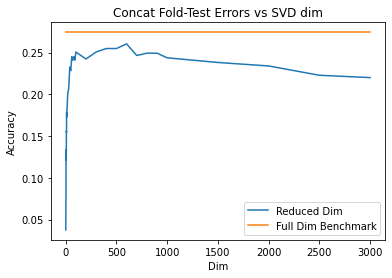

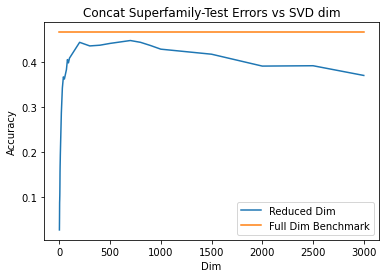

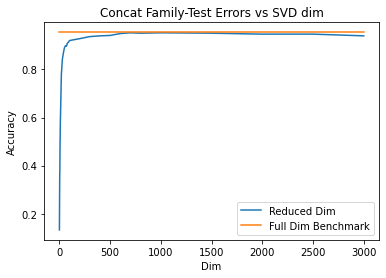

In [86]:
import matplotlib.pyplot as plt

plt.plot(all_dims, fold)
plt.plot(all_dims, fold_benchs)
plt.title("Concat Fold-Test Errors vs SVD dim")
plt.xlabel("Dim")
plt.ylabel("Accuracy")
plt.legend(["Reduced Dim", "Full Dim Benchmark"])
plt.show()

plt.plot(all_dims, superfam)
plt.plot(all_dims, superfam_benchs)
plt.title("Concat Superfamily-Test Errors vs SVD dim")
plt.xlabel("Dim")
plt.ylabel("Accuracy")
plt.legend(["Reduced Dim", "Full Dim Benchmark"])
plt.show()

plt.plot(all_dims, family)
plt.plot(all_dims, family_benchs)
plt.title("Concat Family-Test Errors vs SVD dim")
plt.xlabel("Dim")
plt.ylabel("Accuracy")
plt.legend(["Reduced Dim", "Full Dim Benchmark"])
plt.show()

In [87]:
import pickle
with open("CONCAT_SVD_scores_across_dims.p", "wb") as f:
    pickle.dump(all_dim_all_scores, f)

In [6]:
def get_single_model_normalized_corpus(model):
    ys = []
    Xs = []

    # read all splits
    for split in ['train', 'valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']:

        y_dict = read_dataset('label', task, split)
        X, y = dict_2_arr(read_dataset(model, task, split), y_dict)
        
        ys.append(y)
        Xs.append(X)  
    
    # concat all splits
    corpus = np.concatenate(Xs, axis=0)
    
    return corpus, ys

In [7]:
from scipy.linalg import orthogonal_procrustes

def ensemble_MEAN_orthogonal_procrustes_reps(m1, m2, min_dim=99999999):
    
    print(f"IN m1 shape: {m1.shape}, m2 shape: {m2.shape}")
    
    min_dim = min(min(min_dim, m1.shape[1]), m2.shape[1])
    print("reducing to dim", min_dim)
    
    if m1.shape[1] > min_dim:
        m1 = SVD_reduce_dim(m1, min_dim)
        
    if m2.shape[1] > min_dim:
        m2 = SVD_reduce_dim(m2, min_dim)
  
    print("norm beform", np.linalg.norm(m1 - m2))
          
    # R closely maps m1 to m2
    R, _ = orthogonal_procrustes(m1, m2)
    m1_close_to_m2 = np.matmul(m1, R)

    print("norm after", np.linalg.norm(m1_close_to_m2 - m2))
    
    combined = np.mean([m1_close_to_m2, m2], axis=0)
    
    print(f"OUT combined {combined.shape}")
    
    return combined
   

In [118]:
X_e, y = get_single_model_normalized_corpus('elmo')
X_t, y = get_single_model_normalized_corpus('transformer')

In [119]:
combined_corpus = ensemble_MEAN_orthogonal_procrustes_reps(X_e, X_t)

IN m1 shape: (16281, 1024), m2 shape: (16281, 768)
reducing to dim 768
norm beform 2026.8992876212048
norm after 1619.8840185162273
OUT combined (16281, 768)


In [120]:
# get out training slice
X_train = combined_corpus[:len(ys[0])]
y_train = ys[0]

# scale
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# fit!
clf = fit_logistic(X_train, y_train)

# record train score
train_score = clf.score(X_train, y_train)
print(f"ensemble_MEAN_orthogonal_procrustes_reps train score: ", train_score)

# get slices for remaing splits and score
remain_splits = ['valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']
end = len(ys[0])
for i in range(len(remain_splits)):
    split = remain_splits[i]
    start = end
    end = len(ys[i+1])+start

    X = combined_corpus[start:end]
    y = ys[i+1]

    X = scaler.transform(X)

    test_score = clf.score(X, y)

    print(f"ensemble_MEAN_orthogonal_procrustes_reps {split} score: ", test_score)

reduced to (16281, 768)
fit time:  0:14:49.522873
model train score:  1.0
Done!
ensemble_MEAN_orthogonal_procrustes_reps train score:  1.0
ensemble_MEAN_orthogonal_procrustes_reps valid score:  0.37193460490463215
ensemble_MEAN_orthogonal_procrustes_reps test_fold_holdout score:  0.2562674094707521
ensemble_MEAN_orthogonal_procrustes_reps test_superfamily_holdout score:  0.43370607028753994
ensemble_MEAN_orthogonal_procrustes_reps test_family_holdout score:  0.9355345911949685


In [14]:
X_e, ys = get_single_model_normalized_corpus('elmo')
X_t, ys = get_single_model_normalized_corpus('transformer')
X_u, ys = get_single_model_normalized_corpus('unirep')

In [11]:
from scipy.linalg import orthogonal_procrustes

def ensemble_CONCAT_orthogonal_procrustes_reps(m1, m2, m3):
    
    print(f"IN m1 shape: {m1.shape}, m2 shape: {m2.shape}")
    
    min_dim = min(min(min(99999999, m1.shape[1]), m2.shape[1]), m3.shape[0])
    
    if m1.shape[1] > min_dim:
        m1 = SVD_reduce_dim(m1, min_dim)
        
    if m2.shape[1] > min_dim:
        m2 = SVD_reduce_dim(m2, min_dim)
 
    if m3.shape[1] > min_dim:
        m3 = SVD_reduce_dim(m3, min_dim)
            
    # R closely maps m2 to m1
    R, _ = orthogonal_procrustes(m2, m1)
    m2_R = np.matmul(m2, R)
    
    # R closely maps m3 to m1
    R, _ = orthogonal_procrustes(m3, m1)
    m3_R = np.matmul(m1, R)
    
    # concatenate all corpuses
    combined = np.concatenate([m1, m2_R, m3_R], axis=1)
    
    print(f"OUT combined {combined.shape}")
    
    return combined

In [12]:
combined_corpus = ensemble_CONCAT_orthogonal_procrustes_reps(X_t, X_e, X_u)

IN m1 shape: (16281, 768), m2 shape: (16281, 1024)
OUT combined (16281, 2304)


In [15]:
# get out training slice
X_train = combined_corpus[:len(ys[0])]
y_train = ys[0]

# scale
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# fit!
clf = fit_logistic(X_train, y_train)

# record train score
train_score = clf.score(X_train, y_train)
print(f"ensemble_CONCAT_orthogonal_procrustes_reps train score: ", train_score)

# get slices for remaing splits and score
remain_splits = ['valid', 'test_fold_holdout', 'test_superfamily_holdout', 'test_family_holdout']
end = len(ys[0])
for i in range(len(remain_splits)):
    split = remain_splits[i]
    start = end
    end = len(ys[i+1])+start

    X = combined_corpus[start:end]
    y = ys[i+1]

    X = scaler.transform(X)

    test_score = clf.score(X, y)

    print(f"ensemble_CONCAT_orthogonal_procrustes_reps {split} score: ", test_score)

fit time:  0:36:11.758721
model train score:  1.0
Done!
ensemble_CONCAT_orthogonal_procrustes_reps train score:  1.0
ensemble_CONCAT_orthogonal_procrustes_reps valid score:  0.3923705722070845
ensemble_CONCAT_orthogonal_procrustes_reps test_fold_holdout score:  0.26880222841225626
ensemble_CONCAT_orthogonal_procrustes_reps test_superfamily_holdout score:  0.4536741214057508
ensemble_CONCAT_orthogonal_procrustes_reps test_family_holdout score:  0.949685534591195


In [15]:
weights = [6,3,1]
combined_corpus_weighted, ys = get_combined_normalized_corpus_weighted(weights)

In [16]:
all_dim_all_scores = {}
dims = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
for dim in dims:
    scores = do_conact_SVD(dim, combined_corpus_weighted, ys, weights, scale=False)
    all_dim_all_scores[str(dim)] = scores

=========================Concat-SVD 10 weights: [6, 3, 1]=============================

reduced to (16281, 10)
fit time:  0:09:31.461592
model train score:  0.41592848435595287
Done!
conact then SVD-10 model valid score:  0.14305177111716622
conact then SVD-10 model test_fold_holdout score:  0.1532033426183844
conact then SVD-10 model test_superfamily_holdout score:  0.1805111821086262
conact then SVD-10 model test_family_holdout score:  0.5542452830188679
=========================Concat-SVD 20 weights: [6, 3, 1]=============================

reduced to (16281, 20)
fit time:  0:08:20.013648
model train score:  0.6410402275497765
Done!
conact then SVD-20 model valid score:  0.23024523160762944
conact then SVD-20 model test_fold_holdout score:  0.1894150417827298
conact then SVD-20 model test_superfamily_holdout score:  0.2731629392971246
conact then SVD-20 model test_family_holdout score:  0.7838050314465409
=========================Concat-SVD 50 weights: [6, 3, 1]======================

In [17]:
import pickle
with open(f"CONCAT_SVD_scores_across_dims_weighted_{weights}.p", "wb") as f:
    pickle.dump(all_dim_all_scores, f)